# 第5章の実装

In [65]:
import time
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 


import numpy as np
import pandas as pd
from scipy import stats
from PIL import Image, ImageDraw
from sklearn.decomposition import NMF
from tqdm import tqdm_notebook as tqdm
from scipy.special import digamma as sp_digamma

# NMF

In [2]:
# 今回はサイトから直接データを引っ張ってきている
data_org = pd.read_csv(
   'http://files.grouplens.org/datasets/movielens/ml-100k/u.data', names=["user_id", "item_id", "rating", "timestamp"], sep="\t")
data_org.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
# item_id x user_idの行列に変換する
item_list = data_org.sort_values('item_id').item_id.unique()
user_list = data_org.user_id.unique()
rating_matrix_item = np.zeros([len(item_list), len(user_list)])

In [5]:
rating_matrix_item.shape

(1682, 943)

In [24]:
# Movie Lensのtrain, testを読み込む
movie_data_train = pd.read_csv(
   'data/ml-100k/ua.base', names=["user_id", "item_id", "rating", "timestamp"], sep="\t")
movie_data_test = pd.read_csv(
   'data/ml-100k/ua.test', names=["user_id", "item_id", "rating", "timestamp"], sep="\t")

In [29]:
# trainのuser数, item数
print("train user num : ", len(movie_data_train["user_id"].unique()))
print("train item num : ", len(movie_data_train["item_id"].unique()))
print("test user num : ", len(movie_data_test["user_id"].unique()))
print("test item num : ", len(movie_data_test["item_id"].unique()))


print("共通user数 : ", end="")
print(len(set(movie_data_train["user_id"].unique()) & set(movie_data_test["user_id"].unique())))
print("共通item数 : ", end="")
print(len(set(movie_data_train["item_id"].unique()) & set(movie_data_test["item_id"].unique())))

train user num :  943
train item num :  1680
test user num :  943
test item num :  1129
共通user数 : 943
共通item数 : 1127


In [459]:
movie_data_train.head()

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [460]:
movie_data_test.head()

,user_id,item_id,rating,timestamp
0,1,20,4,887431883
1,1,33,4,878542699
2,1,61,4,878542420
3,1,117,3,874965739
4,1,155,2,878542201


testのみに出現するitemもあることに注意

In [22]:
# 全itemが入っているuser * item　matrixを作成する

In [31]:
np.r_[movie_data_train["user_id"].unique(), movie_data_test["item_id"].unique()]

array([   1,    2,    3, ..., 1258,  570,  808])

In [59]:
item_list

array([   1,    2,    3, ..., 1680, 1681, 1682])

In [63]:
### item_id x user_idの行列に変換する

# train
item_list = np.unique(np.r_[movie_data_train["item_id"].unique(), movie_data_test["item_id"].unique()])
user_list = movie_data_train["user_id"].unique()
rating_matrix_item = np.zeros([len(item_list), len(user_list)])

for item_id in tqdm(item_list):
    user_list_item = movie_data_train[movie_data_train['item_id'] == item_id].sort_values('user_id').user_id.unique()
    for user_id in user_list_item:
        user_rate = movie_data_train[(movie_data_train['item_id'] == item_id) & (movie_data_train['user_id'] == user_id)].loc[:, 'rating']
        if len(user_rate) == 0:
            user_rate = 0
        rating_matrix_item[item_id-1, user_id-1] = user_rate
rating_matrix_train = np.copy(rating_matrix_item)

# test
item_list = np.unique(np.r_[movie_data_train["item_id"].unique(), movie_data_test["item_id"].unique()])
user_list = movie_data_train["user_id"].unique()
rating_matrix_item = np.zeros([len(item_list), len(user_list)])

for item_id in tqdm(item_list):
    user_list_item = movie_data_test[movie_data_test['item_id'] == item_id].sort_values('user_id').user_id.unique()
    for user_id in user_list_item:
        user_rate = movie_data_test[(movie_data_test['item_id'] == item_id) & (movie_data_test['user_id'] == user_id)].loc[:, 'rating']
        if len(user_rate) == 0:
            user_rate = 0
        rating_matrix_item[item_id-1, user_id-1] = user_rate
rating_matrix_test = np.copy(rating_matrix_item)

In [143]:
# 各ユーザーが未評価なitemのフラグ
rated_item_train = np.array(rating_matrix_train != 0, dtype=np.float32)
rated_item_test = np.array(rating_matrix_test != 0, dtype=np.float32)

In [144]:
np.sum(rated_item_train)

90570.0

In [145]:
np.sum(rated_item_test)

9430.0

## Scikit-Learn 実装の NMF
ただし欠損値の考慮がされていない

In [163]:
def calc_rmse(w, h, rating_matrix, target_item):
    '''学習したw, hによる推定評価値のあてはまりの良さを
    userが評価したitemだけを見たRMSEで評価する
    '''
    n = np.sum(target_item)
    target_e = (rating_matrix - np.dot(w, h)) * target_item
    mse = np.sum(target_e ** 2)
    rmse = np.sqrt(mse / n)
    return rmse

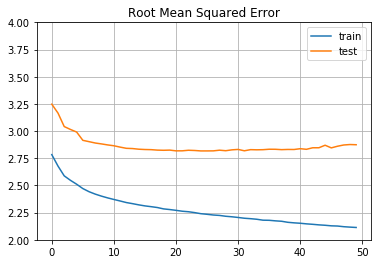

In [188]:
train_rsmes = []
test_rsmes = []
for i in range(50):
    nmf = NMF(n_components=i+1, init='random', random_state=20190405)
    w = nmf.fit_transform(rating_matrix_train)
    h = nmf.components_
    train_rsmes.append(calc_rmse(w, h, rating_matrix_train, rated_item_train))
    test_rsmes.append(calc_rmse(w, h, rating_matrix_test, rated_item_test))
    
plt.plot(np.arange(50), train_rsmes, label="train")
plt.plot(np.arange(50), test_rsmes, label="test")
plt.ylim(2, 4)
plt.legend()
plt.grid()
plt.title("Root Mean Squared Error")
plt.show()

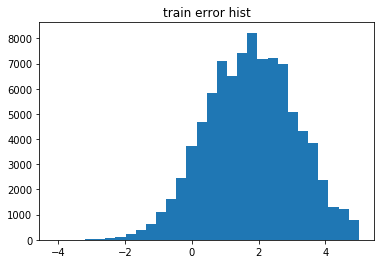

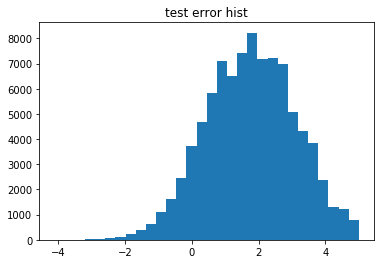

In [186]:
plt.hist((rating_matrix_train - np.dot(w, h))[np.array(rated_item_train, dtype="bool")], bins=30)
plt.title("train error hist")
plt.show()

plt.hist((rating_matrix_train - np.dot(w, h))[np.array(rated_item_train, dtype="bool")], bins=30)
plt.title("test error hist")
plt.show()

## 欠損値を考慮したNMF

In [203]:
def update(rating_matrix, mask, W, H):
    '''欠損値のlossは伝搬させないNMFのW, Hの更新式
    '''
    W = W * np.dot(rating_matrix * mask, H.T) / (np.dot(np.dot(W, H) * mask, H.T)+1e-10)
    H = H * np.dot(W.T, rating_matrix * mask) / (np.dot(W.T, np.dot(W, H) * mask)+1e-10)
    return W, H

In [204]:
def nmf_with_na(rating_matrix, k=10):
    # W, Hをランダムに初期化する
    n, m = rating_matrix.shape
    W = np.random.rand(n, k)
    H = np.random.rand(k, m)
    mask = (rating_matrix > 0)

    for _ in range(100):
        W, H = update(rating_matrix, mask, W, H)
        
    return W, H

In [213]:
train_rsmes = []
test_rsmes = []
for i in range(50):
    w, h = nmf_with_na(rating_matrix_train, k=i+1)
    train_rsmes.append(calc_rmse(w, h, rating_matrix_train, rated_item_train))
    test_rsmes.append(calc_rmse(w, h, rating_matrix_test, rated_item_test))

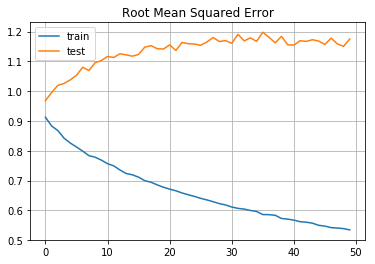

In [212]:
plt.plot(np.arange(50), train_rsmes, label="train")
plt.plot(np.arange(50), test_rsmes, label="test")
# plt.ylim(2, 4)
plt.legend()
plt.grid()
plt.title("Root Mean Squared Error")
plt.show()

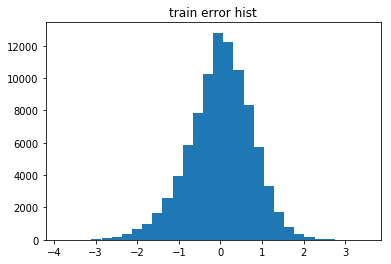

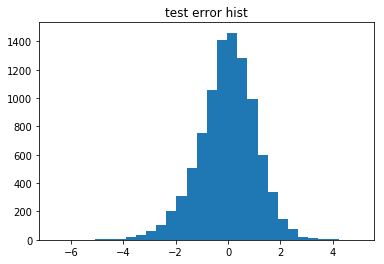

In [215]:
w, h = nmf_with_na(rating_matrix_train, k=10)
plt.hist((rating_matrix_train - np.dot(w, h))[np.array(rated_item_train, dtype="bool")], bins=30)
plt.title("train error hist")
plt.show()

plt.hist((rating_matrix_test - np.dot(w, h))[np.array(rated_item_test, dtype="bool")], bins=30)
plt.title("test error hist")
plt.show()

## ベイズ推論によるNMF

In [434]:
class NMF:
    '''混合ガウスモデルをギブスサンプリングで推定する
    '''
    def __init__(self, a_w, b_w, a_h, b_h, max_iter=10):
        '''事前分布の初期値を設定する
        inputs : a_w, array(n * k), {a_w_i > 0}
                      b_w, array(n * k), {b_w_i > 0}
                      a_h, array(k, m), {a_h_i > 0}
                      b_h, array(k, m), {b_h_i > 0}
                      max_iter, int, max_iter > 0
        '''
        # 確率分布Wのパラメータ
        self.a_w = np.array(a_w)
        self.b_w = np.array(b_w)
        # 確率分布Hのパラメータ
        self.a_h = np.array(a_h)
        self.b_h = np.array(b_h)
        
        self.max_iter = max_iter
        self.k = self.a_w.shape[1]
        self.n = self.a_w.shape[0]
        self.m = self.a_h.shape[1]
        
    def fit(self, X):
        '''データXをみた後の事後分布を更新
        inputs : X, array(n * m),
        return : None
        '''
        
        a_w = np.copy(self.a_w)
        b_w = np.copy(self.b_w)
        a_h = np.copy(self.a_h)
        b_h = np.copy(self.b_h)
        
        # Wの条件付き期待値
        W_ = a_w / b_w
        ln_W_ = sp_digamma(a_w) - np.log(b_w)
        # Hの条件付き期待値
        H_ = a_h / b_h
        ln_H_ = sp_digamma(a_h) - np.log(b_h)
        
        # 補助変数Sのパラメータ
        pi = np.ones((self.n, self.k, self.m, )) / self.k
        # Sの条件付き期待値
        S_ = X.reshape(self.n, 1, self.m) * pi
                
        for i in tqdm(range(self.max_iter)):
            ### 確率分布W, Hのパラメータの更新
            a_w = self.a_w +np.sum(S_, axis=2)
            b_w = self.b_w + np.sum(H_, axis=1)
            a_h = self.a_h +np.sum(S_, axis=0)
            b_h = (self.b_h.T + np.sum(a_w / b_w, axis=0)).T
            
            # 条件付き期待値の更新
            W_ = a_w / b_w
            ln_W_ = sp_digamma(a_w) - np.log(b_w)
            H_ = a_h / b_h
            ln_H_ = sp_digamma(a_h) - np.log(b_h)
            
            ### 確率分布Sのパラメータの更新
            pi = np.zeros((self.n, self.k, self.m))
            S_ = np.zeros((self.n, self.k, self.m))
            pi = np.exp(ln_W_.reshape(self.n, self.k, 1) + ln_H_.reshape(1, self.k, self.m))
            pi = pi / np.sum(pi, axis=1).reshape(self.n, 1, self.m)
            S_ = X.reshape(self.n, 1, self.m) * pi
                    
        # 確率分布Wのパラメータ
        self.a_w = np.array(a_w)
        self.b_w = np.array(b_w)
        # 確率分布Hのパラメータ
        self.a_h = np.array(a_h)
        self.b_h = np.array(b_h)
        
        self.W =  self.a_w / self.b_w
        self.H = self.a_h / self.b_h
        return

In [436]:
k = 10
a_w =np.random.random((n, k))
b_w = np.random.random((n, k))
a_h = np.random.random((k, m))
b_h = np.random.random((k, m))

In [450]:
train_rsmes = []
test_rsmes = []
n = rating_matrix_train.shape[0]
m = rating_matrix_train.shape[1]
a_w =np.random.random((n, k))
b_w = np.random.random((n, k))
a_h = np.random.random((k, m))
b_h = np.random.random((k, m))
k = 10
for i in range(10):
    nmf = NMF(a_w, b_w, a_h, b_h, max_iter=5*(i+1))
    nmf.fit(rating_matrix_train)
    train_rsmes.append(calc_rmse(nmf.W, nmf.H, rating_matrix_train, rated_item_train))
    test_rsmes.append(calc_rmse(nmf.W, nmf.H, rating_matrix_test, rated_item_test))

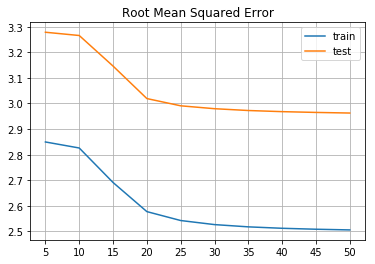

In [454]:
plt.plot(np.arange(10), train_rsmes, label="train")
plt.plot(np.arange(10), test_rsmes, label="test")
# plt.ylim(2, 4)
plt.legend()
plt.grid()
plt.xticks(np.arange(10), (np.arange(10)+1)*5)
plt.title("Root Mean Squared Error")
plt.show()

In [456]:
train_rsmes = []
test_rsmes = []
n = rating_matrix_train.shape[0]
m = rating_matrix_train.shape[1]
for i in range(25):
    k = (i+1)*2
    a_w =np.random.random((n, k))
    b_w = np.random.random((n, k))
    a_h = np.random.random((k, m))
    b_h = np.random.random((k, m))
    nmf = NMF(a_w, b_w, a_h, b_h, max_iter=20)
    nmf.fit(rating_matrix_train)
    train_rsmes.append(calc_rmse(nmf.W, nmf.H, rating_matrix_train, rated_item_train))
    test_rsmes.append(calc_rmse(nmf.W, nmf.H, rating_matrix_test, rated_item_test))

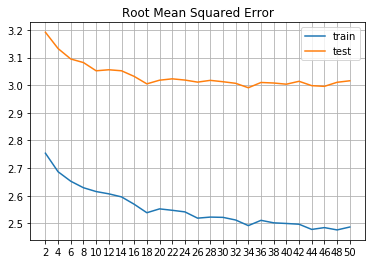

In [457]:
plt.plot(np.arange(25), train_rsmes, label="train")
plt.plot(np.arange(25), test_rsmes, label="test")
# plt.ylim(2, 4)
plt.legend()
plt.grid()
plt.xticks(np.arange(25), (np.arange(25)+1)*2)
plt.title("Root Mean Squared Error")
plt.show()

In [ ]:
class NMF:
    '''混合ガウスモデルをギブスサンプリングで推定する
    '''
    def __init__(self, a_w, b_w, a_h, b_h, max_iter=10):
        '''事前分布の初期値を設定する
        inputs : a_w, array(n * k), {a_w_i > 0}
                      b_w, array(n * k), {b_w_i > 0}
                      a_h, array(k, m), {a_h_i > 0}
                      b_h, array(k, m), {b_h_i > 0}
                      max_iter, int, max_iter > 0
        '''
        # 確率分布Wのパラメータ
        self.a_w = np.array(a_w)
        self.b_w = np.array(b_w)
        # 確率分布Hのパラメータ
        self.a_h = np.array(a_h)
        self.b_h = np.array(b_h)
        
        self.max_iter = max_iter
        self.k = self.a_w.shape[1]
        self.n = self.a_w.shape[0]
        self.m = self.a_h.shape[1]
        
    def fit(self, X):
        '''データXをみた後の事後分布を更新
        inputs : X, array(n * m),
        return : None
        '''
        
        a_w = np.copy(self.a_w)
        b_w = np.copy(self.b_w)
        a_h = np.copy(self.a_h)
        b_h = np.copy(self.b_h)
        
        # Wの条件付き期待値
        W_ = a_w / b_w
        ln_W_ = sp_digamma(a_w) - np.log(b_w)
        # Hの条件付き期待値
        H_ = a_h / b_h
        ln_H_ = sp_digamma(a_h) - np.log(b_h)
        
        # 補助変数Sのパラメータ
        pi = np.ones((self.n, self.k, self.m, )) / self.k
        # Sの条件付き期待値
        S_ = X.reshape(self.n, 1, self.m) * pi
                
        for i in tqdm(range(self.max_iter)):
            ### 確率分布W, Hのパラメータの更新
            a_w = self.a_w +np.sum(S_, axis=2)
            b_w = self.b_w + np.sum(H_, axis=1)
            a_h = self.a_h +np.sum(S_, axis=0)
            b_h = (self.b_h.T + np.sum(a_w / b_w, axis=0)).T
            
            # 条件付き期待値の更新
            W_ = a_w / b_w
            ln_W_ = sp_digamma(a_w) - np.log(b_w)
            H_ = a_h / b_h
            ln_H_ = sp_digamma(a_h) - np.log(b_h)
            
            ### 確率分布Sのパラメータの更新
            pi = np.zeros((self.n, self.k, self.m))
            S_ = np.zeros((self.n, self.k, self.m))
            pi = np.exp(ln_W_.reshape(self.n, self.k, 1) + ln_H_.reshape(1, self.k, self.m))
            pi = pi / np.sum(pi, axis=1).reshape(self.n, 1, self.m)
            S_ = X.reshape(self.n, 1, self.m) * pi
                    
        # 確率分布Wのパラメータ
        self.a_w = np.array(a_w)
        self.b_w = np.array(b_w)
        # 確率分布Hのパラメータ
        self.a_h = np.array(a_h)
        self.b_h = np.array(b_h)
        
        self.W =  self.a_w / self.b_w
        self.H = self.a_h / self.b_h
        return